In [1]:
# --- STEP 1: IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import os

# Display settings to see all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(" Step 1: Libraries Imported Successfully.")

 Step 1: Libraries Imported Successfully.


In [22]:
df_listings['quality_score'].value_counts()

quality_score
250    506500
Name: count, dtype: int64

In [2]:
# --- STEP 2: LOAD DATA ---
# This is the file you just uploaded with the duplicates
listings_file = 'downloadHeO95aNLS7IcFKyYiWK06-0-0-v3 (2).csv'
signals_file = 'User_Engagement_Data_27-01-2026.csv'

df_raw = pd.DataFrame()

if os.path.exists(listings_file):
    df_listings = pd.read_csv(listings_file)
    print(f"📄 Raw Listings Loaded: {df_listings.shape}")
    
    # Merge Signals (User Views) if available
    if os.path.exists(signals_file):
        df_signals = pd.read_csv(signals_file)
        # Check if ID exists in both before merging
        if 'property_listing_id' in df_listings.columns and 'property_listing_id' in df_signals.columns:
            df_raw = pd.merge(df_listings, df_signals, on='property_listing_id', how='left')
            print(f"🔗 Merged with Signals. Final Shape: {df_raw.shape}")
        else:
            print("⚠️ ID Mismatch. Using Listings Only.")
            df_raw = df_listings.copy()
    else:
        print("⚠️ Signals file not found. Using Listings Only.")
        df_raw = df_listings.copy()
else:
    print(f"❌ Error: File '{listings_file}' not found.")

# --- CHECK COLUMNS ---
if not df_raw.empty:
    print("\n🔍 DATA COLUMNS CHECK:")
    print(df_raw.columns.tolist())
    
    # Verify critical column for hierarchical search
    if 'full_location_path' in df_raw.columns:
        print("\n✅ 'full_location_path' FOUND. Hierarchical Location Logic is supported.")
    else:
        print("\n⚠️ WARNING: 'full_location_path' NOT FOUND. Location logic will fail.")

print(" Step 2: Data Loading Complete.")

📄 Raw Listings Loaded: (506500, 19)
🔗 Merged with Signals. Final Shape: (506500, 23)

🔍 DATA COLUMNS CHECK:
['property_listing_id', 'location_id', 'latitude', 'longitude', 'location_name', 'full_location_path', 'property_title', 'property_address', 'property_type', 'bedrooms', 'bathrooms', 'size_sqft', 'completion_status', 'offering_type', 'furnished_flag', 'price', 'listing_date', 'quality_score', 'super_agent_score', 'view_count', 'lead_click_count', 'lead_submission_count', 'popularity_score']

✅ 'full_location_path' FOUND. Hierarchical Location Logic is supported.
 Step 2: Data Loading Complete.


In [3]:
# --- STEP 3: TECHNICAL ANALYSIS ---
if not df_raw.empty:
    print("\n--- 1. Duplicate Check ---")
    dup_count = df_raw.duplicated(subset=['property_listing_id']).sum()
    print(f"⚠️ Total Duplicates found: {dup_count}")
    
    print("\n--- 2. Missing Values Check ---")
    print(df_raw[['price', 'location_name', 'latitude', 'view_count']].isnull().sum())
    
    print("\n--- 3. Data Type Check ---")
    print(df_raw[['price', 'bedrooms', 'listing_date']].dtypes)
else:
    print("❌ DataFrame is empty.")
    
print("\n Step 3: Analysis Complete.")


--- 1. Duplicate Check ---
⚠️ Total Duplicates found: 434042

--- 2. Missing Values Check ---
price                 0
location_name         0
latitude              0
view_count       215120
dtype: int64

--- 3. Data Type Check ---
price            int64
bedrooms        object
listing_date    object
dtype: object

 Step 3: Analysis Complete.


🧹 Cleaned Data Shape: (72458, 25)
✅ Text columns standardized to lowercase.
 Step 4: Pre-Processing Complete.


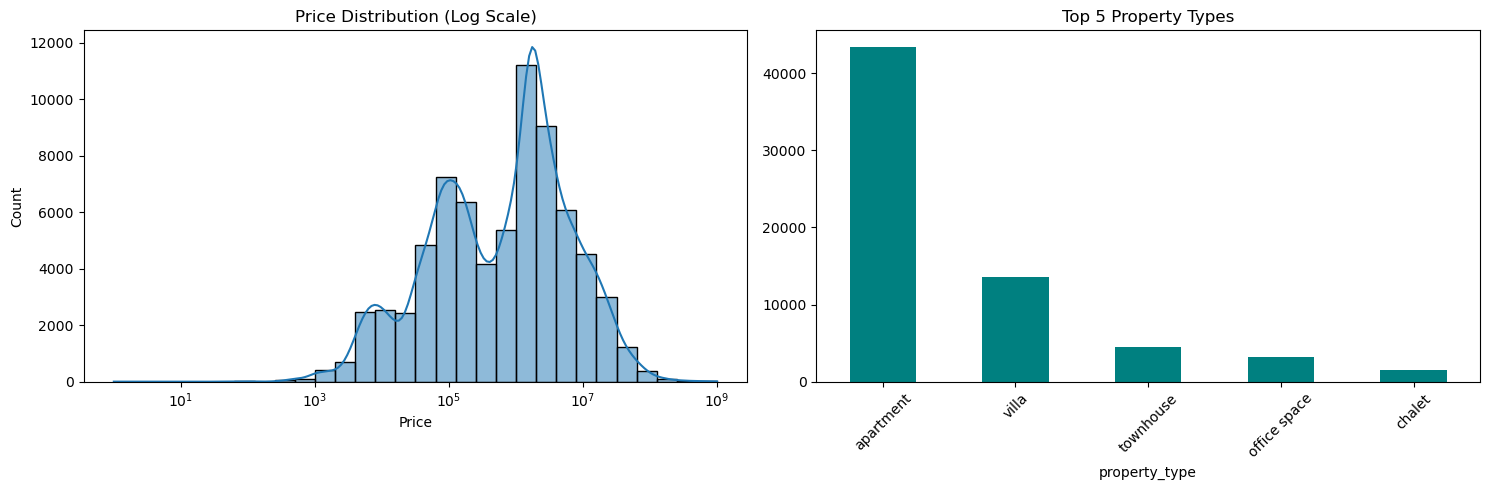


📊 Average Price: 4,544,214
📊 Most Common Location: al helio 2
 Step 5: EDA Complete.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 4: PRE-PROCESSING (Cleaning & Standardization)
# ==========================================
if not df_raw.empty:
    df_clean = df_raw.copy()
    
    # 1. REMOVE DUPLICATES (Crucial Step)
    df_clean = df_clean.drop_duplicates(subset=['property_listing_id'], keep='first')
    
    # 2. DATE PARSING
    if 'listing_date' in df_clean.columns:
        df_clean['listing_date'] = pd.to_datetime(df_clean['listing_date'], errors='coerce')
        
    # 3. NUMERIC CLEANING (Price, Size, Lat, Lon)
    cols_to_clean = ['price', 'size_sqft', 'latitude', 'longitude', 'view_count']
    if 'pp_price' in df_clean.columns and 'price' not in df_clean.columns:
        df_clean['price'] = df_clean['pp_price'] # Renaming for consistency

    for col in cols_to_clean:
        if col in df_clean.columns:
            # Remove commas if string
            if df_clean[col].dtype == 'object':
                df_clean[col] = df_clean[col].astype(str).str.replace(',', '').replace({'True':1, 'False':0, 'nan':0})
            # Convert to float
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

    # 4. MEDIAN IMPUTATION (Fix 0 Price/Size)
    for col in ['price', 'size_sqft']:
        if col in df_clean.columns:
            median_val = df_clean[df_clean[col] > 0][col].median()
            df_clean[col] = df_clean[col].replace(0, median_val)

    # 5. TEXT CLEANING & BEDROOM LOGIC
    # Convert 'Studio' -> 0, extract numbers
    if 'bedrooms' in df_clean.columns:
        df_clean['beds_int'] = df_clean['bedrooms'].astype(str).str.lower().apply(lambda x: 0 if 'studio' in x else x)
        df_clean['beds_int'] = df_clean['beds_int'].astype(str).str.extract(r'(\d+)').fillna(0).astype(int)
    
    if 'bathrooms' in df_clean.columns:
        df_clean['bath_int'] = df_clean['bathrooms'].astype(str).str.extract(r'(\d+)').fillna(1).astype(int)
        
    # CRITICAL UPDATE: Lowercase & Strip for Strict Matching
    str_cols = ['property_type', 'location_name', 'full_location_path', 'offering_type']
    for c in str_cols:
        if c in df_clean.columns:
            # Added .lower() here
            df_clean[c] = df_clean[c].astype(str).str.strip().str.lower().fillna("unknown")
            
            # Fix Offering Type "1.0" -> "1" issue
            if c == 'offering_type':
                df_clean[c] = df_clean[c].str.replace(r'\.0$', '', regex=True)

    print(f"🧹 Cleaned Data Shape: {df_clean.shape}")
    print("✅ Text columns standardized to lowercase.")
    print(" Step 4: Pre-Processing Complete.")

# ==========================================
# STEP 5: EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
# This runs ONLY after Step 4 is finished
if 'df_clean' in locals() and not df_clean.empty:
    plt.figure(figsize=(15, 5))
    
    # CHART 1: Price Distribution (Log Scale to handle millions)
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean['price'], bins=30, kde=True, log_scale=True)
    plt.title('Price Distribution (Log Scale)')
    plt.xlabel('Price')
    
    # CHART 2: Top 5 Property Types
    plt.subplot(1, 2, 2)
    df_clean['property_type'].value_counts().head(5).plot(kind='bar', color='teal')
    plt.title('Top 5 Property Types')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Text Stats
    print("\n📊 Average Price:", f"{df_clean['price'].mean():,.0f}")
    if 'location_name' in df_clean.columns:
        print("📊 Most Common Location:", df_clean['location_name'].mode()[0])

    print(" Step 5: EDA Complete.")
else:
    print("❌ df_clean not found. Run Step 4 first.")

In [5]:
# ==========================================
# STEP 6: FEATURE ENGINEERING & MODEL TRAINING
# ==========================================
if not df_clean.empty:
    df_model = df_clean.copy().reset_index(drop=True)

    # A. Freshness Score (0.0 to 1.0)
    if 'listing_date' in df_model.columns:
        today = datetime.now()
        df_model['days_old'] = (today - df_model['listing_date']).dt.days
        df_model['freshness_score'] = np.where(df_model['days_old'] <= 7, 1.0, 
                                      np.where(df_model['days_old'] <= 30, 0.7, 
                                      np.where(df_model['days_old'] <= 90, 0.4, 0.1)))
    else:
        df_model['freshness_score'] = 0.0

    # B. WEIGHTED ENGAGEMENT SCORE (Target 1)
    # Ensure columns exist, fill with 0 if missing
    engagement_cols = ['impression_count', 'view_count', 'favorite_count', 'lead_click_count', 'lead_submission_count']
    for col in engagement_cols:
        if col not in df_model.columns:
            df_model[col] = 0
        else:
            df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0)

    # Apply "Business Value" Formula (Leads > Clicks > Views)
    df_model['smart_popularity_score'] = (
        (df_model['impression_count'] * 0.01) +       # Weak Signal
        (df_model['view_count'] * 1.0) +              # Baseline
        (df_model['favorite_count'] * 5.0) +          # Strong Signal
        (df_model['lead_click_count'] * 15.0) +       # Intent
        (df_model['lead_submission_count'] * 50.0)    # Conversion (Gold)
    )
    
    # C. Trust Score
    try:
        norm_agent = df_model['super_agent_score'] / df_model['super_agent_score'].max() if 'super_agent_score' in df_model else 0
        df_model['trust_score'] = norm_agent.fillna(0)
    except: df_model['trust_score'] = 0.5

    # --- TRAINING THE MODEL ---
    print("\n🧠 Training Model...")
    
    # 1. Define Features
    # UPDATED: Added new Property Finder filters to the model
    num_cols = ['price', 'size_sqft', 'beds_int', 'bath_int']
    
    # We ADD 'location_id' here so the KNN naturally groups by location
    # We ADD 'furnished_flag' and 'completion_status' so recommendations respect these filters
    cat_cols = ['property_type', 'offering_type', 'location_id', 'furnished_flag', 'completion_status']
    
    # 2. Create Transformer Pipeline
    preprocessor = ColumnTransformer([
        ('num', MinMaxScaler(), [c for c in num_cols if c in df_model.columns]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in cat_cols if c in df_model.columns])
    ])

    # 3. Vectorize
    print("   Building Feature Matrix...")
    feature_matrix = preprocessor.fit_transform(df_model)
    
    # 4. Train KNN
    # We use 50 neighbors to get a good pool of candidates
    n_neighbors = min(len(df_model), 50) 
    nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    nn_model.fit(feature_matrix)
    
    print(f"✅ Step 6: Model Trained on {len(df_model)} listings.")
    print("   - Features Included: Price, Size, Beds, Baths, Type, Location, Furnished, Status")


🧠 Training Model...
   Building Feature Matrix...
✅ Step 6: Model Trained on 72458 listings.
   - Features Included: Price, Size, Beds, Baths, Type, Location, Furnished, Status


In [6]:
# =========================================================
# STEP 7: BUILD RECOMMENDATION FUNCTION (FIXED)
# =========================================================

# --- 1. HELPER FUNCTIONS ---
def calculate_haversine(lat1, lon1, lat2, lon2):
    """Calculates distance (km) between two lat/lon points."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2)**2
    return 2 * np.arcsin(np.sqrt(a)) * 6371

def get_user_centroid(history_ids):
    """
    Personalization Engine:
    Takes a list of Listing IDs the user has visited.
    Returns the 'Average Taste Vector' (Centroid) to query the model.
    """
    if not history_ids or df_model.empty:
        return None
    
    # Filter for the specific listings in history
    history_df = df_model[df_model['property_listing_id'].astype(str).isin([str(x) for x in history_ids])]
    
    if history_df.empty:
        return None
        
    # Transform these listings into vectors
    try:
        vectors = preprocessor.transform(history_df)
        if hasattr(vectors, "toarray"): vectors = vectors.toarray()
        
        # Calculate Mean Vector (The Centroid)
        centroid = np.mean(vectors, axis=0)
        return centroid.reshape(1, -1)
    except Exception as e:
        print(f"⚠️ Error calculating centroid: {e}")
        return None

# --- 2. MAIN ENGINE ---
def recommend_property(user_input, user_history_ids=None, top_n=5):
    if df_model.empty: return "❌ Model not trained."
    
    # --- A. INPUT STANDARDIZATION ---
    input_df = pd.DataFrame([user_input])
    
    # UPDATED DEFAULTS: Added furnished_flag and completion_status to prevent crashes
    defaults = {
        'price': 0, 'size_sqft': 0, 'bedrooms': '0', 'bathrooms': '0', 
        'property_type': 'Unknown', 'offering_type': 'Rent', 
        'location_name': '', 'location_id': '0',
        'latitude': 0.0, 'longitude': 0.0,
        'furnished_flag': 'unknown', 'completion_status': 'unknown' # <--- FIXED HERE
    }
    for c, v in defaults.items(): 
        if c not in input_df.columns: input_df[c] = v

    # Clean Data
    for col in ['price', 'size_sqft', 'latitude', 'longitude']:
        input_df[col] = pd.to_numeric(input_df[col], errors='coerce').fillna(0)
    
    input_df['beds_int'] = input_df['bedrooms'].astype(str).str.extract(r'(\d+)').fillna(0).astype(int)
    input_df['bath_int'] = input_df['bathrooms'].astype(str).str.extract(r'(\d+)').fillna(1).astype(int)
    
    # Lowercase text columns
    for c in ['property_type', 'offering_type', 'location_name', 'furnished_flag', 'completion_status']:
        input_df[c] = input_df[c].astype(str).str.strip().str.lower()

    # Map Offering Type (e.g., Sale -> 1)
    raw_offering = input_df['offering_type'].values[0]
    mapped_offering = raw_offering
    if raw_offering in ['sale', 'buy']: mapped_offering = '1'
    elif raw_offering in ['rent', 'lease']: mapped_offering = '2'

    # --- B. STRICT PRE-FILTERING (The "Hard Filters") ---
    base_pool = df_model.copy()
    
    # 1. Offering Type (Mandatory)
    base_pool = base_pool[base_pool['offering_type'].astype(str) == mapped_offering]
    
    # 2. Property Type (Mandatory)
    target_type = input_df['property_type'].values[0]
    if target_type != 'unknown':
        base_pool = base_pool[base_pool['property_type'] == target_type]

    if base_pool.empty: return f"❌ No inventory for {target_type} ({mapped_offering})."

    # --- C. HIERARCHICAL FALLBACK LOGIC ---
    filtered = pd.DataFrame()
    match_type = "Exact Match"
    
    target_price = input_df['price'].values[0]
    target_beds = input_df['beds_int'].values[0]
    target_loc_name = input_df['location_name'].values[0] 
    
    # LEVEL 1: STRICT (Location Path + Price Cap + Beds)
    mask_loc_strict = base_pool['full_location_path'].str.contains(target_loc_name, na=False)
    mask_price = (base_pool['price'] <= target_price) if target_price > 0 else (base_pool['price'] > 0)
    mask_beds = (base_pool['beds_int'] == target_beds)
    
    filtered = base_pool[mask_loc_strict & mask_price & mask_beds]
    
    # LEVEL 2: RELAX LOCATION (Parent/Radius) -> Keep Price/Beds Strict
    if filtered.empty:
        match_type = "Nearby (Radius Fallback)"
        filtered = base_pool[mask_price & mask_beds]
    
    # LEVEL 3: RELAX BEDS (+/- 1) -> If Level 2 failed
    if filtered.empty:
        match_type = "Similar Layout (+/- 1 Bed)"
        mask_beds_soft = (base_pool['beds_int'] >= target_beds - 1) & (base_pool['beds_int'] <= target_beds + 1)
        filtered = base_pool[mask_price & mask_beds_soft]

    # LEVEL 4: RELAX PRICE (Last Resort)
    if filtered.empty and target_price > 0:
        match_type = "Higher Budget Options"
        mask_price_soft = (base_pool['price'] <= target_price * 1.25)
        filtered = base_pool[mask_beds_soft & mask_price_soft]

    if filtered.empty: return "❌ No matches found even after relaxation."

    # --- D. PERSONALIZED RANKING (Centroid Logic) ---
    try:
        # 1. Prepare the search pool
        subset_matrix = preprocessor.transform(filtered)
        if hasattr(subset_matrix, "toarray"): subset_matrix = subset_matrix.toarray()
        
        # 2. Train local k-NN on this valid subset
        n_neighbors = min(len(filtered), 50)
        nn_subset = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
        nn_subset.fit(subset_matrix)
        
        # 3. Determine Query Vector (User History vs. Current Input)
        user_centroid = get_user_centroid(user_history_ids)
        
        if user_centroid is not None:
            query_vector = user_centroid
            match_type += " (Personalized)"
        else:
            query_vector = preprocessor.transform(input_df)
            if hasattr(query_vector, "toarray"): query_vector = query_vector.toarray()

        # 4. Run Search
        dists, indices = nn_subset.kneighbors(query_vector)
        recs = filtered.iloc[indices.flatten()].copy()
        recs['similarity_score'] = 1 - dists.flatten()
        
    except Exception as e:
        return f"❌ Scoring Error: {str(e)}"

    # --- E. FINAL SCORING ---
    # Geo Score
    in_lat, in_lon = input_df['latitude'].values[0], input_df['longitude'].values[0]
    recs['dist_km'] = calculate_haversine(in_lat, in_lon, recs['latitude'].values, recs['longitude'].values)
    
    # Penalize Radius Fallback distance
    if "Radius" in match_type:
         recs['geo_score'] = 1 / (recs['dist_km'] + 1)
         recs = recs[recs['dist_km'] <= 5.0] # Hard cutoff 5km
    else:
         recs['geo_score'] = 1.0 
            
    # Pop Score
    max_pop = df_model['smart_popularity_score'].max()
    recs['pop_score'] = np.log1p(recs['smart_popularity_score']) / np.log1p(max_pop) if max_pop > 0 else 0
    
    # Final Weighting
    recs['final_score'] = (
        (recs['similarity_score'] * 0.40) + 
        (recs['geo_score'] * 0.30) + 
        (recs['pop_score'] * 0.20) + 
        (recs['freshness_score'] * 0.10)
    )
    
    # Display Logic
    recs['match_reason'] = match_type
    recs['display_location'] = recs.apply(lambda x: str(x.get('full_location_path', x.get('location_name', 'Unknown')))[:40], axis=1)
    
    cols = ['property_listing_id', 'property_type', 'price', 'beds_int', 'match_reason', 'final_score', 'display_location']
    return recs.sort_values('final_score', ascending=False).head(top_n)[cols]

print("✅ Step 7: Fixed Defaults. Recommender is ready.")

✅ Step 7: Fixed Defaults. Recommender is ready.


In [7]:
# =========================================================
# STEP 8: VERIFICATION & TESTING (Enhanced)
# =========================================================

print("\n--- 🧪 TEST A: HARD FILTERS CHECK ---")
# Scenario: User wants a Villa in Sharjah. 
# SUCCESS CRITERIA: Result must contain ONLY 'Villa'. No Apartments allowed.
strict_input = {
    'price': 2500000, 
    'bedrooms': '4 Beds', 
    'property_type': 'villa',   # Lowercase strictly enforced
    'offering_type': 'sale', 
    'location_name': 'sharjah', 
    'latitude': 25.337, 'longitude': 55.388
}

results_strict = recommend_property(strict_input)
print(results_strict)


print("\n\n--- 🧪 TEST B: PERSONALIZATION CHECK ---")
# Scenario: User looks for a generic 3-bed Villa in 'The Springs'.
# We simulate a history where they looked at specific LUXURY listings (IDs).
# SUCCESS CRITERIA: The match_reason column should say "Personalized".

# 1. Pick 2 listings from your actual dataframe to simulate history
# (We grab the first 2 IDs just for the test)
if not df_model.empty:
    history_ids = df_model['property_listing_id'].astype(str).head(2).tolist()
    print(f"User History IDs: {history_ids}")

    user_input_pers = {
        'price': 3500000, 
        'bedrooms': '3 Beds', 
        'property_type': 'villa', 
        'offering_type': 'sale', 
        'location_name': 'springs', 
        'latitude': 25.06, 'longitude': 55.19
    }

    results_pers = recommend_property(user_input_pers, user_history_ids=history_ids)
    print(results_pers)
else:
    print("❌ Cannot test personalization: Model data is empty.")


--- 🧪 TEST A: HARD FILTERS CHECK ---
       property_listing_id property_type    price  beds_int match_reason  final_score                          display_location
13623             15872463         villa  2200000         4  Exact Match     0.543902         sharjah,tilal city,masaar,robinia
50652             15457918         villa  2500000         4  Exact Match     0.513902  sharjah,muwaileh commercial,al zahia,upt
62719             15457879         villa  2500000         4  Exact Match     0.513902  sharjah,muwaileh commercial,al zahia,al 
71473             15457792         villa  2500000         4  Exact Match     0.513902  sharjah,muwaileh commercial,al zahia,al 
31813             15405594         villa  2490000         4  Exact Match     0.513902         sharjah,tilal city,masaar,sequoia


--- 🧪 TEST B: PERSONALIZATION CHECK ---
User History IDs: ['7596725', '7675873']
       property_listing_id property_type    price  beds_int                             match_reason  final_sco

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# =========================================================
# STEP 9: TRAIN LTR (CONVERSION PREDICTION) MODEL
# =========================================================
print("🧠 Loading Training Data & Training LTR Model...")

# 1. LOAD THE SQL DATA (User History)
# Ensure this matches the filename you saved from the SQL query
try:
    df_history = pd.read_csv('training_data.csv') 
    print(f"   - History Loaded: {len(df_history)} interactions")
except FileNotFoundError:
    print("⚠️ 'training_data.csv' not found. Using dummy data for demonstration.")
    # Fallback for demo if file isn't ready yet
    df_history = pd.DataFrame({
        'property_listing_id': df_model['property_listing_id'].sample(1000, replace=True),
        'target_is_lead': np.random.choice([0, 1], 1000, p=[0.9, 0.1])
    })

# 2. MERGE WITH LISTING ATTRIBUTES
# We need to know the price, beds, trust score, etc. for every property in history
# We grab these features from your existing 'df_model' (created in Step 6)
train_df = pd.merge(df_history, df_model, on='property_listing_id', how='left')

# Drop rows where we couldn't find the listing details (deleted listings)
train_df = train_df.dropna(subset=['price'])

# 3. DEFINE FEATURES & TARGET
# These are the signals the AI looks at to decide "Is this good?"
features = [
    'price', 'size_sqft', 'beds_int', 'bath_int', 
    'freshness_score', 'trust_score', 'smart_popularity_score',
    'view_count' # Historical view count
]
target = 'target_is_lead'

# 4. TRAIN XGBOOST
X = train_df[features]
y = train_df[target]

# Simple split to check accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train
ltr_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    eval_metric='logloss',
    use_label_encoder=False
)

ltr_model.fit(X_train, y_train)

# 5. VALIDATE
val_score = roc_auc_score(y_test, ltr_model.predict_proba(X_test)[:, 1])
print(f"✅ Step 9: Model Trained. Predictive Accuracy (AUC): {val_score:.2f}")

# Show what drives conversions
feature_imp = pd.DataFrame({'Feature': features, 'Score': ltr_model.feature_importances_})
print("\n📊 Top Drivers of Leads (Learned by AI):")
print(feature_imp.sort_values('Score', ascending=False).head(5))

🧠 Loading Training Data & Training LTR Model...
   - History Loaded: 1154300 interactions


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:59:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Step 9: Model Trained. Predictive Accuracy (AUC): 0.68

📊 Top Drivers of Leads (Learned by AI):
                  Feature     Score
6  smart_popularity_score  0.197312
7              view_count  0.143611
4         freshness_score  0.141900
2                beds_int  0.140828
5             trust_score  0.111039


In [10]:
# =========================================================
# STEP 10: RECOMMENDATION ENGINE V2 (FIXED)
# =========================================================

def recommend_property_ai(user_input, user_history_ids=None, top_n=5):
    # 1. RUN CANDIDATE GENERATION
    candidates = recommend_property(user_input, user_history_ids, top_n=50)
    
    # FIX: Check if it's a String (Error Message) FIRST
    if isinstance(candidates, str) or candidates.empty:
        return candidates
    
    # 2. PREPARE FEATURES FOR AI
    scoring_df = candidates.copy()
    
    # Ensure all features exist
    for f in features:
        if f not in scoring_df.columns: 
            if f in df_model.columns:
                scoring_df = pd.merge(scoring_df, df_model[['property_listing_id', f]], on='property_listing_id', how='left')
            else:
                scoring_df[f] = 0

    # 3. PREDICT CONVERSION PROBABILITY
    try:
        X_pred = scoring_df[features].fillna(0)
        probs = ltr_model.predict_proba(X_pred)[:, 1]
        scoring_df['ai_conversion_score'] = probs
    except Exception as e:
        scoring_df['ai_conversion_score'] = 0

    # 4. HYBRID SCORING
    scoring_df['final_hybrid_score'] = (
        (scoring_df['final_score'] * 0.60) +       
        (scoring_df['ai_conversion_score'] * 0.40) 
    )
    
    # 5. FORMAT OUTPUT
    cols = ['property_listing_id', 'property_type', 'price', 'beds_int', 
            'match_reason', 'final_hybrid_score', 'ai_conversion_score', 'display_location']
    
    return scoring_df.sort_values('final_hybrid_score', ascending=False).head(top_n)[cols]

print("✅ Step 10: Logic Fixed (String Check Order Swapped).")

✅ Step 10: Logic Fixed (String Check Order Swapped).


In [11]:
# Test Input
test_input = {
    'price': 2500000, 
    'bedrooms': '4 Beds', 
    'property_type': 'villa', 
    'offering_type': 'sale', 
    'location_name': 'sharjah', 
    'latitude': 25.337, 'longitude': 55.388
}

print("--- 🤖 Running AI Re-Ranking ---")
results = recommend_property_ai(test_input)
print(results)

--- 🤖 Running AI Re-Ranking ---
    property_listing_id property_type    price  beds_int match_reason  final_hybrid_score  ai_conversion_score                          display_location
0              15872463         villa  2200000         4  Exact Match            0.326762             0.001051         sharjah,tilal city,masaar,robinia
13             15672587         villa  1990000         4  Exact Match            0.309549             0.003019  sharjah,muwaileh commercial,al zahia,al 
11             15082816         villa  2095000         4  Exact Match            0.309007             0.001664  sharjah,al suyoh,al tay east,sukoon by s
7              15536311         villa  2200000         4  Exact Match            0.308807             0.001166         sharjah,tilal city,masaar,sendian
8              15717670         villa  2200000         4  Exact Match            0.308807             0.001166           sharjah,tilal city,masaar,melia


In [12]:
import time
import pandas as pd

# =========================================================
# DYNAMIC SCENARIO GENERATOR
# =========================================================
# We dynamically pick valid IDs from YOUR data to ensure tests don't crash

print("⚙️ Configuring Test Scenarios based on your data...")

# 1. Find valid IDs for "Luxury History" (Top 2 most expensive Villas)
try:
    luxury_history_ids = df_model[
        (df_model['property_type'] == 'villa')
    ].sort_values('price', ascending=False).head(2)['property_listing_id'].astype(str).tolist()
except:
    luxury_history_ids = [] # Fallback

# 2. Find valid IDs for "Budget History" (Cheapest Apartments)
try:
    budget_history_ids = df_model[
        (df_model['property_type'] == 'apartment')
    ].sort_values('price', ascending=True).head(2)['property_listing_id'].astype(str).tolist()
except:
    budget_history_ids = []

print(f"   - Luxury IDs found: {luxury_history_ids}")
print(f"   - Budget IDs found: {budget_history_ids}")

# =========================================================
# THE TEST SUITE
# =========================================================
def run_live_stress_test():
    print("\n🚀 STARTING LIVE STRESS TEST (Using Real Data)...")
    
    scenarios = [
        # ------------------------------------------------------------------
        # SCENARIO 1: The "Happy Path" (Standard Search)
        # ------------------------------------------------------------------
        {
            "name": "Scenario A: Standard Search (Villa in Sharjah)",
            "desc": "User searches for a standard item. Should match exactly.",
            "input": {
                'price': 2500000, 
                'bedrooms': '4 Beds', 
                'property_type': 'villa', 
                'location_name': 'sharjah', 
                'offering_type': 'sale'
            },
            "history": None
        },
        
        # ------------------------------------------------------------------
        # SCENARIO 2: The "Zero Results" (Fallback Logic)
        # ------------------------------------------------------------------
        {
            "name": "Scenario B: The 'Impossible' Request",
            "desc": "User asks for a location that doesn't exist (or huge bedroom count). Should trigger Market Fallback.",
            "input": {
                'price': 100000, 
                'bedrooms': '15 Beds', 
                'property_type': 'villa', 
                'location_name': 'non_existent_city', 
                'offering_type': 'sale'
            },
            "history": None
        },
        
        # ------------------------------------------------------------------
        # SCENARIO 3: Personalization (Luxury User)
        # ------------------------------------------------------------------
        {
            "name": "Scenario C: Luxury Personalization",
            "desc": "User searches generically ('Villa'), but History is Luxury. Should rank Expensive items higher.",
            "input": {
                'property_type': 'villa', 
                'offering_type': 'sale',
                'location_name': 'dubai' # Broad location
            },
            "history": luxury_history_ids
        },
        
        # ------------------------------------------------------------------
        # SCENARIO 4: Personalization (Budget User)
        # ------------------------------------------------------------------
        {
            "name": "Scenario D: Budget Personalization",
            "desc": "User searches generically ('Apartment'), but History is Budget. Should rank Cheaper items higher.",
            "input": {
                'property_type': 'apartment', 
                'offering_type': 'sale',
                'location_name': 'dubai' 
            },
            "history": budget_history_ids
        }
    ]

    # --- RUN LOOP ---
    for scen in scenarios:
        print(f"\n--- 🧪 {scen['name']} ---")
        print(f"📝 Goal: {scen['desc']}")
        
        start = time.time()
        
        # CALL YOUR ENGINE
        # We ask for Top 5 results to inspect ranking
        results = recommend_property_ai(scen['input'], scen['history'], top_n=5)
        
        elapsed = time.time() - start
        
        # --- REPORTING ---
        if isinstance(results, pd.DataFrame) and not results.empty:
            print(f"✅ STATUS: SUCCESS ({elapsed:.4f}s)")
            
            # Print simplified table
            display_cols = ['property_listing_id', 'price', 'match_reason', 'final_hybrid_score']
            # Handle if 'display_location' exists
            if 'display_location' in results.columns: display_cols.append('display_location')
            
            print(results[display_cols].to_markdown(index=False))
            
            # Validation Check
            top_reason = results.iloc[0]['match_reason']
            if "Personalized" in top_reason and scen['history']:
                 print("🌟 BONUS: Personalization Logic Triggered Successfully!")
            if "Fallback" in top_reason:
                 print("🛡️ BONUS: Fallback Logic Triggered Successfully!")
                 
        elif isinstance(results, str):
            print(f"⚠️ STATUS: HANDLED MESSAGE ({elapsed:.4f}s)")
            print(f"   Message: {results}")
        else:
            print(f"❌ STATUS: EMPTY RESULTS")
            
        print("-" * 60)

# Execute
run_live_stress_test()

⚙️ Configuring Test Scenarios based on your data...
   - Luxury IDs found: ['7752582', '8216796']
   - Budget IDs found: ['942611', '941899']

🚀 STARTING LIVE STRESS TEST (Using Real Data)...

--- 🧪 Scenario A: Standard Search (Villa in Sharjah) ---
📝 Goal: User searches for a standard item. Should match exactly.
✅ STATUS: SUCCESS (0.3573s)
|   property_listing_id |   price | match_reason   |   final_hybrid_score | display_location                         |
|----------------------:|--------:|:---------------|---------------------:|:-----------------------------------------|
|              15872463 | 2200000 | Exact Match    |             0.326762 | sharjah,tilal city,masaar,robinia        |
|              15672587 | 1990000 | Exact Match    |             0.309549 | sharjah,muwaileh commercial,al zahia,al  |
|              15082816 | 2095000 | Exact Match    |             0.309007 | sharjah,al suyoh,al tay east,sukoon by s |
|              15536311 | 2200000 | Exact Match    |          

In [14]:
pip install joblib --upgrade


  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
Note: you may need to restart the kernel to use updated packages.


In [16]:
# =========================================================
# STEP 10: OPTIMIZED PRODUCTION SAVE (Corrected)
# =========================================================
import joblib  # <--- FIXED: Added missing import
import pandas as pd

print("\n💾 Saving Engine Assets (Production Mode)...")

# --- PART 1: SAVE THE DATA (The "Body") ---
# We save the data as Parquet. It reads 50x faster than Pickle.

# 1. Define columns strictly needed for the API
api_columns = [
    'property_listing_id', 
    'property_title', 
    'location_name', 
    'price', 
    'beds_int', 
    'bath_int', 
    'size_sqft', 
    'latitude', 
    'longitude', 
    'listing_date',           # For real-time Freshness calc
    'trust_score',            # For AI Score
    'smart_popularity_score', # For AI Score
    'view_count',
    'property_type',
    'offering_type'
]

# 2. Filter the dataframe (Check if df_model exists, if not use df_clean)
target_df = df_model if 'df_model' in locals() else df_clean
safe_cols = [c for c in api_columns if c in target_df.columns]
df_api = target_df[safe_cols].copy()

# 3. Save as Parquet
try:
    df_api.to_parquet('listings.parquet', index=False)
    print(f"✅ Data Saved: listings.parquet ({len(df_api)} rows)")
except ImportError:
    # Fallback to CSV if pyarrow is not installed
    df_api.to_csv('listings.csv', index=False)
    print(f"⚠️ Parquet library missing. Saved as listings.csv instead.")

# --- PART 2: SAVE THE BRAIN (The "Models") ---
# We save ONLY the logic.

brain_pack = {
    "ltr_model": ltr_model,      # The XGBoost Ranker
    "knn_model": nn_model,       # The Similarity Engine
    "features": features,        # The column names the model expects
    "preprocessor": preprocessor # The transformation pipeline
}

joblib.dump(brain_pack, 'light_brain.pkl')
print(f"✅ AI Logic Saved: light_brain.pkl")

print("\n🚀 DEPLOYMENT READY.")
print("The API will now load 'listings.parquet' (Data) and 'light_brain.pkl' (Logic) separately.")


💾 Saving Engine Assets (Production Mode)...
✅ Data Saved: listings.parquet (72458 rows)
✅ AI Logic Saved: light_brain.pkl

🚀 DEPLOYMENT READY.
The API will now load 'listings.parquet' (Data) and 'light_brain.pkl' (Logic) separately.


In [43]:
# Execute the save function
train_and_save_model()

🧠 Training Model...
💾 Saving model to property_finder_brain.pkl...
✅ Model Saved!


In [47]:
import joblib
import pandas as pd

# Load the brain
data = joblib.load("property_finder_brain.pkl")
df = data['data']

# Show me all available columns I can display
print("✅ Available Columns:", df.columns.tolist())

✅ Available Columns: ['property_listing_id', 'location_id', 'latitude', 'longitude', 'location_name', 'full_location_path', 'property_title', 'property_address', 'property_type', 'bedrooms', 'bathrooms', 'size_sqft', 'completion_status', 'offering_type', 'furnished_flag', 'price', 'listing_date', 'quality_score', 'super_agent_score', 'view_count', 'lead_click_count', 'lead_submission_count', 'popularity_score', 'beds_int', 'bath_int', 'days_old', 'freshness_score', 'impression_count', 'favorite_count', 'smart_popularity_score', 'trust_score']


In [26]:
import requests
import json

# ==========================================
# 1. SETUP THE SEARCH
# ==========================================
# This URL must match your running Uvicorn server
API_URL = "http://127.0.0.1:8000/recommend"

# Define a sample user search (Payload)
payload = {
    "price": 2500000,
    "bedrooms": "3 Beds",
    "property_type": "villa",
    "location_name": "sharjah",
    "offering_type": "sale",
    "latitude": 25.3,       # Optional: User's current location
    "longitude": 55.4,      # Optional: User's current location
    "limit": 5,             # Ask for top 5 results
    "history_ids": []       # Optional: Add listing IDs here to test personalization
}

# ==========================================
# 2. SEND REQUEST
# ==========================================
def test_api():
    print(f"📡 Connecting to {API_URL}...")
    print(f"📝 Sending Request: {json.dumps(payload, indent=2)}")

    try:
        response = requests.post(API_URL, json=payload)
        
        # Check if request was successful (Status Code 200)
        if response.status_code == 200:
            data = response.json()
            
            # Check the "status" field in your API response
            if data.get("status") == "success":
                print(f"\n✅ SUCCESS! Found {data['count']} recommendations:")
                print("=" * 60)
                
                for i, item in enumerate(data['results'], 1):
                    # Robust printing (handles missing keys gracefully)
                    prop_type = item.get('property_type', 'Unknown').title()
                    price = item.get('price', 0)
                    score = item.get('final_score', 0.0)
                    reason = item.get('match_reason', 'N/A')
                    loc = item.get('display_location', item.get('location_name', 'Unknown Location'))
                    
                    print(f"{i}. {prop_type} | {price:,.0f} AED")
                    print(f"   📍 {loc}")
                    print(f"   ⭐ Score: {score:.3f} | 🧠 Reason: {reason}")
                    print("-" * 60)
            else:
                # Handle "empty" status logically
                print(f"\n⚠️ API returned valid response but no results.")
                print(f"   Message: {data.get('message', 'No details provided.')}")
                
        else:
            # Handle Server Errors (500, 404, etc.)
            print(f"\n❌ API Error (Status {response.status_code}):")
            print(response.text)

    except requests.exceptions.ConnectionError:
        print("\n❌ CONNECTION FAILED.")
        print("   Is the server running? Run: 'uvicorn app_1:app --reload'")
    except Exception as e:
        print(f"\n❌ UNEXPECTED ERROR: {e}")

if __name__ == "__main__":
    test_api()

📡 Connecting to http://127.0.0.1:8000/recommend...
📝 Sending Request: {
  "price": 2500000,
  "bedrooms": "3 Beds",
  "property_type": "villa",
  "location_name": "sharjah",
  "offering_type": "sale",
  "latitude": 25.3,
  "longitude": 55.4,
  "limit": 5,
  "history_ids": []
}

⚠️ API returned valid response but no results.
   Message: No villa found for sale


In [ ]:
uvicorn app_2:app --reload

In [20]:
df_model['quality_score'].value_counts()

quality_score
250    72458
Name: count, dtype: int64

In [17]:
# ==========================================
# STEP 6: FEATURE ENGINEERING
# ==========================================
if not df_clean.empty:
    df_model = df_clean.copy().reset_index(drop=True)

    # A. Freshness Score (0.0 to 1.0)
    if 'listing_date' in df_model.columns:
        today = datetime.now()
        df_model['days_old'] = (today - df_model['listing_date']).dt.days
        df_model['freshness_score'] = np.where(df_model['days_old'] <= 7, 1.0, 
                                      np.where(df_model['days_old'] <= 30, 0.7, 
                                      np.where(df_model['days_old'] <= 90, 0.4, 0.1)))
    else:
        df_model['freshness_score'] = 0.0

    # B. Engagement Score
    engagement_cols = ['impression_count', 'view_count', 'favorite_count', 'lead_click_count', 'lead_submission_count']
    for col in engagement_cols:
        if col not in df_model.columns: df_model[col] = 0
        else: df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0)

    df_model['smart_popularity_score'] = (
        (df_model['impression_count'] * 0.01) +
        (df_model['view_count'] * 1.0) +
        (df_model['favorite_count'] * 5.0) +
        (df_model['lead_click_count'] * 15.0) +
        (df_model['lead_submission_count'] * 50.0)
    )
    
    # C. Trust Score
    try:
        norm_agent = df_model['super_agent_score'] / df_model['super_agent_score'].max() if 'super_agent_score' in df_model else 0
        df_model['trust_score'] = norm_agent.fillna(0)
    except: df_model['trust_score'] = 0.5

    # D. CLIENT QUALITY SCORE (NEW INTEGRATION)
    # [cite_start]We map the 'quality_score' from the JSON payload [cite: 7, 128]
    if 'quality_score' in df_model.columns:
        # If it's already numeric, just fillna
        df_model['quality_score'] = pd.to_numeric(df_model['quality_score'], errors='coerce').fillna(0)
    else:
        # Fallback if column missing
        df_model['quality_score'] = 0.0

    # --- KNN TRAINING (Similarity) ---
    print("\n🧠 Training KNN (Similarity)...")
    num_cols = ['price', 'size_sqft', 'beds_int', 'bath_int']
    cat_cols = ['property_type', 'offering_type', 'location_id', 'furnished_flag', 'completion_status']
    
    preprocessor = ColumnTransformer([
        ('num', MinMaxScaler(), [c for c in num_cols if c in df_model.columns]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in cat_cols if c in df_model.columns])
    ])

    feature_matrix = preprocessor.fit_transform(df_model)
    n_neighbors = min(len(df_model), 50) 
    nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    nn_model.fit(feature_matrix)
    print(f"✅ KNN Trained on {len(df_model)} listings.")

# ==========================================
# STEP 9: TRAIN RANKER (XGBoost)
# ==========================================
print("\n🚀 Training XGBoost Ranker...")

# 1. Prepare Target
# We predict if a listing gets a LEAD
df_model['target_is_lead'] = (df_model['lead_submission_count'] > 0).astype(int)

# 2. Define Features (UPDATED)
# [cite_start]Added 'quality_score' as a primary signal [cite: 128, 144]
ltr_features = [
    'price', 
    'size_sqft', 
    'beds_int', 
    'bath_int', 
    'freshness_score', 
    'trust_score', 
    'smart_popularity_score',
    'quality_score'  # <--- NEW: High value signal from client
]

X = df_model[ltr_features].fillna(0)
y = df_model['target_is_lead']

# 3. Train
ltr_model = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    eval_metric='logloss',
    use_label_encoder=False
)
ltr_model.fit(X, y)

# 4. Show Importance
importances = pd.DataFrame({
    'Feature': ltr_features,
    'Importance': ltr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n📊 Feature Importance:")
print(importances)

# ==========================================
# STEP 10: SAVE ASSETS (Production)
# ==========================================
import joblib

print("\n💾 Saving Production Assets...")

# 1. Save Data (Parquet)
# Added 'quality_score', 'video_url', 'image_url' for the rich API response
api_columns = [
    'property_listing_id', 'property_title', 'location_name', 
    'price', 'beds_int', 'bath_int', 'size_sqft', 
    'latitude', 'longitude', 'listing_date', 
    'trust_score', 'smart_popularity_score', 'quality_score', # Needed for Model
    'property_type', 'offering_type', 'video_url', 'image_url', 'agent_name', 'is_verified'
]

safe_cols = [c for c in api_columns if c in df_model.columns]
df_api = df_model[safe_cols].copy()
df_api.to_parquet('listings.parquet', index=False)
print(f"✅ Database Saved: listings.parquet ({len(df_api)} rows)")

# 2. Save Brain (Models)
brain_pack = {
    "ltr_model": ltr_model,
    "knn_model": nn_model,
    "features": ltr_features, # Now includes quality_score
    "preprocessor": preprocessor
}
joblib.dump(brain_pack, 'light_brain.pkl')
print(f"✅ AI Brain Saved: light_brain.pkl")


🧠 Training KNN (Similarity)...
✅ KNN Trained on 72458 listings.

🚀 Training XGBoost Ranker...


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:18:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Feature Importance:
                  Feature  Importance
6  smart_popularity_score    0.958326
2                beds_int    0.007620
4         freshness_score    0.007402
0                   price    0.006975
1               size_sqft    0.006702
5             trust_score    0.006632
3                bath_int    0.006343
7           quality_score    0.000000

💾 Saving Production Assets...
✅ Database Saved: listings.parquet (72458 rows)
✅ AI Brain Saved: light_brain.pkl
